# Task 2

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 200)
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

import json
from urllib import request

# Import all packages related to Modelling
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import time

import warnings
warnings.filterwarnings('ignore')

In /Users/mk/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/mk/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/mk/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# User input parameters

# boolean flag if the transactions should be obtained via web API or directly from the stored files 
# Note: it's preferred to load transactions from files because via web API it can take a while
load_saved_trans = True

# CSV files where transactions are stored or should be stored after they were extracted via web API
mal_trans_filename = 'all_malicious_trans.csv'
white_trans_filename = 'all_white_trans.csv'

# set the max number of transactions which can extracted via web API per account
offset = 10000 # should be <= 10000
# set random state for data shuffling and splitting
random_state = 42

## A.1. Create a list of malicious addresses.  

In [3]:
# Opening JSON file
f = open('malicious_adresses')
# returns JSON object as a dictionary
data = json.load(f)
 
# Iterating through the json list
mal_adress = {}
for d in data:
    mal_adress[d['address']] = d['comment']

# Closing file
f.close()
print(len(mal_adress))

663


##  B.2. Download data about the transaction of the malicious addresses. 


In [4]:
def get_account_info(address_list, save_filename=''):
    
    """
        Read all the accounts transactions via Etherscan web API.
        Args:
            address_list: List of account names to read transactions from
            save_filename: str, if the filename is provided the transactions data will be stored in CSV file
        Returns:
            Dataframe which contains the account name and all the transactions related to that account
    """
    
    all_trans = [] # init the list to store all the transactions for each malicious account
    acc_names = [] # list to store the names of all accounts duplicated by the amount of transactions (will be added to DataFrame later)

    for ind, add in enumerate(address_list):
        print(f'{ind} --> address: {add}', end='  ')
        # read the address -> get all transactions
        try:
            webUrl = request.urlopen(f"https://api.etherscan.io/api\
?module=account\
&action=txlist\
&address={add}\
&startblock=0\
&endblock=99999999\
&page=1\
&offset={offset}\
&sort=asc\
&apikey=CXPXR9E8E8BXFDQZ2I3URWAVRJ4T2CR6XM") # ApiKeyToken
        except Exception as e:
            print('ERROR:', e)
            continue

        # convert the API response from byte array into string
        data = webUrl.read().decode("utf-8") 
        data = json.loads(data) # convert string into JSON dict
        all_trans += data['result']
        res_len = len(data['result'])
        print(f'result_len = {res_len}')
        acc_names += [add]*res_len

    trans_df = pd.DataFrame(all_trans)
    trans_df.insert(0, 'acc_name', acc_names)
    
    # save to CSV File so we don't need to use API each time to access the transactions
    if len(save_filename):
        trans_df.to_csv(save_filename)
    return trans_df

In [5]:
if load_saved_trans:
    if os.path.exists(mal_trans_filename):
        all_trans_df = pd.read_csv(mal_trans_filename, index_col=0)
    else:
        print(f'File {mal_trans_filename} cannot be found...')
else:
    all_trans_df = get_account_info(list(mal_adress.keys()), mal_trans_filename)
all_trans_df

,acc_name,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,gas,gasPrice,isError,txreceipt_status,input,contractAddress,cumulativeGasUsed,gasUsed,confirmations
0,0x09750ad360fdb7a2ee23669c4503c974d86d8694,11275378,1605615264,0x999c2bdb82c20445c92a6393810703ee4686b8c4ba85...,0,0x2458147a652c273e82065c8132e9c654cafb770b134e...,139,0xc28f50625cfe028ab1a3458c7cebcf9657ff1438,0x09750ad360fdb7a2ee23669c4503c974d86d8694,5654695700000000000,21000,47000000000,0,1.0,0x,NaN,8249488,21000,3077338
1,0x09750ad360fdb7a2ee23669c4503c974d86d8694,11275378,1605615264,0x857353b26c1dac296de6dc561624f1d1e1e767ed3566...,0,0x2458147a652c273e82065c8132e9c654cafb770b134e...,180,0x22764de8f82f2d2a90e0ccca4556a2a5114b6461,0x09750ad360fdb7a2ee23669c4503c974d86d8694,5642037410000000000,21000,44000000000,0,1.0,0x,NaN,12283162,21000,3077338
2,0x09750ad360fdb7a2ee23669c4503c974d86d8694,11275380,1605615299,0x64d3fee5a1167a09d38ae37239e8927aab90d7cc5b73...,0,0x76e327dda1a6d18cec116d289a5c20ec56a1f57b191a...,39,0x14130d36b36887620c37a404f859d11e293ec06a,0x09750ad360fdb7a2ee23669c4503c974d86d8694,5608978340000000000,21000,47000000000,0,1.0,0x,NaN,3687065,21000,3077336
3,0x09750ad360fdb7a2ee23669c4503c974d86d8694,11275383,1605615311,0x69365605994f1b0194d9321625934cef4e7e29d49045...,0,0xd8cadc54fc2460a132299ff32076f2252bd45796b75e...,115,0x2f77f4523a13138b472ac6faef624cce68da2c46,0x09750ad360fdb7a2ee23669c4503c974d86d8694,5640211030000000000,21000,47000000000,0,1.0,0x,NaN,6441939,21000,3077333
4,0x09750ad360fdb7a2ee23669c4503c974d86d8694,11275385,1605615331,0x006384968d5c18fbbb22cd880cd42ce893646a4c63c1...,0,0x4c87eb63ea27b2107348e6639ac6c6f5d71c3855a6e6...,142,0x2315314c5cadb895c2c9982b847fd6f6a32d6129,0x09750ad360fdb7a2ee23669c4503c974d86d8694,5541052970000000000,21000,47000000000,0,1.0,0x,NaN,9526405,21000,3077331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21849,0xDdd6854A002A6fbcDF695385cD5ed630c9E27C3e,7265417,1551087860,0x56081d2c17ad6b15e31ee7932546d7ee12c432f4ee98...,56,0xcf4da43c616f7a80d7892b94ffc26d9886936ec24ae6...,107,0xddd6854a002a6fbcdf695385cd5ed630c9e27c3e,0xbb4f001ef35d77e9d86b63ea41f57292eba403a1,23539543562508970862,21000,23000000000,0,1.0,0x,NaN,3501377,21000,7087339
21850,0xDdd6854A002A6fbcDF695385cD5ed630c9E27C3e,7265428,1551088045,0x553d68530b0dc30168cad152d8d681386f31d59144ea...,57,0x25264e6d13dca6739df18f0fcf1831dbbcbd795e8841...,89,0xddd6854a002a6fbcdf695385cd5ed630c9e27c3e,0xe96a2365b1819e60dca00d747e4a03cbf5a77c26,22970353887014571818,21000,23000000000,0,1.0,0x,NaN,3426068,21000,7087328
21851,0xDdd6854A002A6fbcDF695385cD5ed630c9E27C3e,7269518,1551171326,0x71dc207851fd5b575c61bc03f037b921de1e99048fe5...,58,0xf09f88a5c9c743fcff317127b0ec4ec9ccc36ed57be9...,306,0xddd6854a002a6fbcdf695385cd5ed630c9e27c3e,0x5d93161bf9a79ef06518f1c671973b3d7b9d3901,9000000000000000000,21000,23000000000,0,1.0,0x,NaN,7963052,21000,7083238
21852,0xDdd6854A002A6fbcDF695385cD5ed630c9E27C3e,7278789,1551358924,0x45948672bf53d95e67f8c47732cb6225848ac807db00...,81,0xb8cfa9fc4cdc9bb569a40d762c4cd13c7ece773e0433...,17,0x5d93161bf9a79ef06518f1c671973b3d7b9d3901,0xddd6854a002a6fbcdf695385cd5ed630c9e27c3e,9000000000000000000,21000,23000000000,0,1.0,0x,NaN,2947077,21000,7073967


In [37]:
all_trans_df.columns

Index(['acc_name', 'blockNumber', 'timeStamp', 'hash', 'nonce', 'blockHash',
       'transactionIndex', 'from', 'to', 'value', 'gas', 'gasPrice', 'isError',
       'txreceipt_status', 'input', 'contractAddress', 'cumulativeGasUsed',
       'gasUsed', 'confirmations'],
      dtype='object')

### Data Preprocessing

In [6]:
def trans_preprocess(df:pd.DataFrame, datetime_col:list, num_cols:list, obj_cols:list, convert2eth=True):
    """
        Function to clean and preprocess the transactions dataframe
        Args:
            df: Input dataframe with all the transactions
            datetime_col: List of length 1 of a datetime column which should be processed and converted to datetime objects
            num_cols: List of numerical columns which should be converted to int/floats types
            obj_cols: List of object (string) columns which should be converted to lowercase format to be consistent
            convert2eth: binary flag which indicated if 'value' and 'gasPrice' columns should be converted to ETH or not
        Returns:
            Dataframe with only datetime_cols + num_cols + obj_cols and processed data.
    """
    # convert all 'useful' num_cols to numerical type
    for c in num_cols + datetime_col:
        if c == 'value': # out of Integer range -> apply type conversion to get floats
            df[c] = df[c].astype('float')
        else:
            df[c] = pd.to_numeric(df[c], errors = 'coerce')

    # convert all addresses to lower case
    for c in obj_cols:
        df[c] = df[c].str.lower()
        df[c].fillna('', inplace=True)

    # convert Unix seconds to datetime 
    df[datetime_col[0]] = pd.to_datetime(df[datetime_col[0]], unit='s', errors='ignore')
    df = df[obj_cols + datetime_col + num_cols]
    
    # convert gas prices from wei/Gwei to ETH
    if convert2eth:
        df['value'] = df['value'] / (10**(18))
        df['gasPrice'] = df['gasPrice'] / (10**(18))

    return df

In [7]:
# List of meaningful features
datetime_col = ['timeStamp']
# extract only useful numerical columns using which a transaction behavior can be analyzed
num_cols = ['value', 'gasPrice', 'isError', 'gasUsed'] 
# Note: 'txreceipt_status' column was added only for transactions starting from 16/10/2017 and all transactions
# before that date has NaNs
obj_cols = ['acc_name', 'from', 'to']

all_mal_trans_df = trans_preprocess(all_trans_df, datetime_col, num_cols, obj_cols)

all_mal_trans_df

,acc_name,from,to,timeStamp,value,gasPrice,isError,gasUsed
0,0x09750ad360fdb7a2ee23669c4503c974d86d8694,0xc28f50625cfe028ab1a3458c7cebcf9657ff1438,0x09750ad360fdb7a2ee23669c4503c974d86d8694,2020-11-17 12:14:24,5.654696,4.700000e-08,0,21000
1,0x09750ad360fdb7a2ee23669c4503c974d86d8694,0x22764de8f82f2d2a90e0ccca4556a2a5114b6461,0x09750ad360fdb7a2ee23669c4503c974d86d8694,2020-11-17 12:14:24,5.642037,4.400000e-08,0,21000
2,0x09750ad360fdb7a2ee23669c4503c974d86d8694,0x14130d36b36887620c37a404f859d11e293ec06a,0x09750ad360fdb7a2ee23669c4503c974d86d8694,2020-11-17 12:14:59,5.608978,4.700000e-08,0,21000
3,0x09750ad360fdb7a2ee23669c4503c974d86d8694,0x2f77f4523a13138b472ac6faef624cce68da2c46,0x09750ad360fdb7a2ee23669c4503c974d86d8694,2020-11-17 12:15:11,5.640211,4.700000e-08,0,21000
4,0x09750ad360fdb7a2ee23669c4503c974d86d8694,0x2315314c5cadb895c2c9982b847fd6f6a32d6129,0x09750ad360fdb7a2ee23669c4503c974d86d8694,2020-11-17 12:15:31,5.541053,4.700000e-08,0,21000
...,...,...,...,...,...,...,...,...
21849,0xddd6854a002a6fbcdf695385cd5ed630c9e27c3e,0xddd6854a002a6fbcdf695385cd5ed630c9e27c3e,0xbb4f001ef35d77e9d86b63ea41f57292eba403a1,2019-02-25 09:44:20,23.539544,2.300000e-08,0,21000
21850,0xddd6854a002a6fbcdf695385cd5ed630c9e27c3e,0xddd6854a002a6fbcdf695385cd5ed630c9e27c3e,0xe96a2365b1819e60dca00d747e4a03cbf5a77c26,2019-02-25 09:47:25,22.970354,2.300000e-08,0,21000
21851,0xddd6854a002a6fbcdf695385cd5ed630c9e27c3e,0xddd6854a002a6fbcdf695385cd5ed630c9e27c3e,0x5d93161bf9a79ef06518f1c671973b3d7b9d3901,2019-02-26 08:55:26,9.000000,2.300000e-08,0,21000
21852,0xddd6854a002a6fbcdf695385cd5ed630c9e27c3e,0x5d93161bf9a79ef06518f1c671973b3d7b9d3901,0xddd6854a002a6fbcdf695385cd5ed630c9e27c3e,2019-02-28 13:02:04,9.000000,2.300000e-08,0,21000


## B.3. Create a set of useful features that describe the behavior of the malicious address within the blockchain 


### Data Exploration / Grouping

In [8]:
# define some help functions for data partitioning

def count_zero_trans(x, no_contract_list:list):
    """
        Compute the total number of zero-valued transactions per account.
        Accounts which run smart contracts are ignored.            
    """
    if x.name in no_contract_list:
        return sum(x == 0)
    return 0

# find the average transaction fee per account
def aver_trans_fee(x):
    """
        Returns the average ETH value spent on the transaction (transaction fee)
    """
    return (x['gasUsed'] * x['gasPrice']).mean()

def count_addresses(x, is_unique=False):
    """
        Computes the total number of (unique) accounts sent to or received from the specific account
    """
    if is_unique:
        return sum([1 for v in set(x) if v != x.name])
    return sum([1 for v in x if v != x.name])

def time_between_trans(x, is_median=True):
    """
        Compute the median/mean time (in seconds) between two consecutive transactions for each acccount
    """
    if len(x) < 2:
        return 0
    x.sort_values(inplace=True)
    out = pd.Series([y.total_seconds() for y in x - x.shift(1)])
    if is_median:
        return out.median()
    return out.mean()


In [9]:
def build_features(input_df:pd.DataFrame):
    
    """
        Function to generate features using which the financial behaviour of the accounts can be analyzed
        Args:
            input_df: DataFrame which contains all the transactions for all the accounts which should be processed
        Returns:
            DataFrame with built features
    """
    
    # create empty dataframe to store the aggregated info about accounts
    all_trans_grouped = pd.DataFrame(index=set(input_df['acc_name']))
    
    # add binary feature column by setting 1 to accounts with empty 'to' fields and 0 otherwise
    contracts_trans = input_df.loc[[len(x)== 0 for x in input_df['to']], 'acc_name'].unique()
    print("#Accounts which run smart contract transactions:", len(contracts_trans))    
    all_trans_grouped['is_contract'] = [np.where(x in contracts_trans, 1, 0) for x in all_trans_grouped.index]
    
    # for regular transactions (not smart contracts) compute the #transactions with 0 value 
    no_contract_acc = input_df.loc[input_df['value']==0, 'acc_name'].unique()
    no_contract_acc = [x for x in no_contract_acc if x not in all_trans_grouped.loc[all_trans_grouped['is_contract'] == 1].index]
    all_trans_grouped['#zero_values'] = input_df.groupby('acc_name')['value'].apply(lambda x: count_zero_trans(x, no_contract_acc))
    
    # count number of error transactions per account
    all_trans_grouped['#error_trans'] = input_df.groupby('acc_name')['isError'].sum()

    # find the average transaction fee per account
    all_trans_grouped['aver_trans_fee'] = input_df.groupby('acc_name')[['gasUsed', 'gasPrice']].apply(aver_trans_fee)

    # find average #ETH sent per account
    all_trans_df_sent = input_df.loc[input_df['from'] == input_df['acc_name']]
    all_trans_grouped['value_sent_mean'] = all_trans_df_sent.groupby(by='acc_name')['value'].mean() # .agg({'value_ETH' : [min, 'mean', max]})

    # find average #ETH received per account
    all_trans_df_receive = input_df.loc[input_df['to'] == input_df['acc_name']]
    all_trans_grouped['value_rec_mean'] = all_trans_df_receive.groupby(by='acc_name')['value'].mean() # .agg({'value_ETH' : [min, 'mean', max]})

    # add total ETH value IN vs total ETH value OUT
    # Note: might be highly correlated with average ETH values sent/received
    all_trans_grouped['value_sent_all'] = all_trans_df_sent.groupby(by='acc_name')['value'].sum()
    all_trans_grouped['value_rec_all'] = all_trans_df_receive.groupby(by='acc_name')['value'].sum()
    
    # total #receive transactions per account
    all_trans_grouped['total_rec_trans'] = input_df.groupby('acc_name')['from'].apply(lambda x: 
                                                                           count_addresses(x, is_unique = False))
    # total #unique_receive transactions per account
    all_trans_grouped['#unique_rec_acc'] = input_df.groupby('acc_name')['from'].apply(lambda x: 
                                                                                count_addresses(x, is_unique = True))
    # total #sent transactions per account
    all_trans_grouped['total_sent_trans'] = input_df.groupby('acc_name')['to'].apply(lambda x: 
                                                                                count_addresses(x, is_unique = False))
    # total #unique_sent transactions per account
    all_trans_grouped['#unique_sent_acc'] = input_df.groupby('acc_name')['to'].apply(lambda x: 
                                                                                count_addresses(x, is_unique = True))
    
    # median time between the transactions for each account
    all_trans_grouped['median_trans_time'] = input_df.groupby('acc_name')['timeStamp'].apply(lambda x: 
                                                                            time_between_trans(x, is_median=True))

    return all_trans_grouped.fillna(0)


    

In [10]:
all_mal_trans_grouped = build_features(all_mal_trans_df)
all_mal_trans_grouped

#Accounts which run smart contract transactions: 147


,is_contract,#zero_values,#error_trans,aver_trans_fee,value_sent_mean,value_rec_mean,value_sent_all,value_rec_all,total_rec_trans,#unique_rec_acc,total_sent_trans,#unique_sent_acc,median_trans_time
0xfcdd417b449c982fc9b6d7b117e417682e81b627,0,0,0,0.000735,0.498740,0.500000,0.498740,0.500000,1,1,1,1,406387.0
0x09cc69f6b484cada8e152d2002adfca496d723f3,1,0,0,0.000446,0.000000,0.000000,0.000000,0.000000,6,3,1,1,151929.0
0xc593e92ed9fd3c2f9db972860047affd2df83ae7,1,0,0,0.000334,0.000000,0.000000,0.000000,0.000000,8,4,1,1,75507.0
0x434e9f6a1ac134fda3e7ceb3fd67c3d9b3518737,0,44,3,0.000615,1.356462,3.340603,86.813548,86.855669,26,26,64,58,363.0
0x8f0bca6b1b2b522082d46f3eec31340f113b029a,0,0,0,0.000583,2.628626,0.292148,7.885877,7.887998,27,27,3,3,16885.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xe6c51d563f92a23dee9a7093bb1be33bd35c05d8,1,0,0,0.000716,0.000000,0.000000,0.000000,0.000000,5,3,1,1,441036.0
0x94b40ecc7b38f5a9316b03dac4fc663e4d10cd15,0,0,0,0.000660,2.934812,0.733918,2.934812,2.935673,4,4,1,1,3458.5
0x62ee4a3c690c9660762c52bf1a232365c86c879b,0,0,0,0.000504,6.442345,0.644279,6.442345,6.442786,10,10,1,1,53992.0
0xa0d67bf1ae91b6b705abd4f695cc13edaacd0d02,0,0,0,0.000968,0.999093,1.000000,0.999093,1.000000,1,1,1,1,2167961.0


## C.1&2. Analyze the addresses' behavior. Group the addresses in several categories based on their behavior.

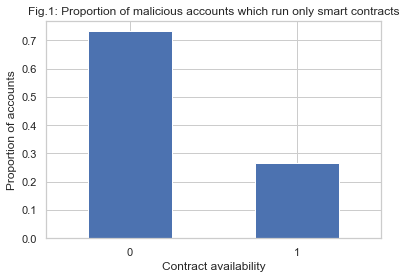

In [11]:
# Bar plot to compare malicious accounts which run the smart contracts vesrus which not
(all_mal_trans_grouped['is_contract'].value_counts() / len(all_mal_trans_grouped)).plot.bar()
plt.xticks(rotation=360);
plt.xlabel('Contract availability')
plt.ylabel('Proportion of accounts')
plt.title('Fig.1: Proportion of malicious accounts which run only smart contracts');

### From now on we consider only malicious accounts which do not run smart contracts and try to group them

In [12]:
def bar_plot(x:pd.Series, y:pd.Series, bins:list, xlabel='', ylabel='', title=''):
    """
        Bar plot function with manually adjusted bins
    """
    ratio = (x / y).round(2).replace(float('inf'), 0)
    ratio_binned = pd.cut(ratio, bins=bins)
    plot_df = (ratio_binned.value_counts() / len(ratio_binned))
    plot_df = plot_df.iloc[plot_df.index.argsort()]
    plot_df.plot.bar()
    plt.xticks(rotation=45);
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title);

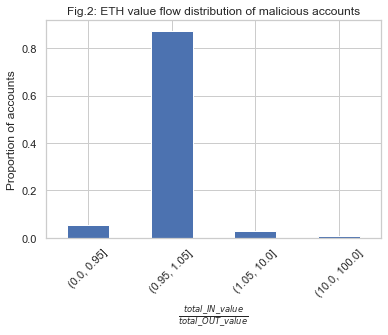

In [13]:
no_contract_trans = all_mal_trans_grouped[all_mal_trans_grouped['is_contract'] == 0]

# ETH value flow: ration of total IN transactions value / total OUT transactions value
bins = [0, 0.95, 1.05, 10, 100]
bar_plot(no_contract_trans['value_rec_all'], no_contract_trans['value_sent_all'], 
        bins=bins, xlabel=r'$\frac{total\_IN\_value}{total\_OUT\_value}$',
        ylabel='Proportion of accounts', title='Fig.2: ETH value flow distribution of malicious accounts'
        )

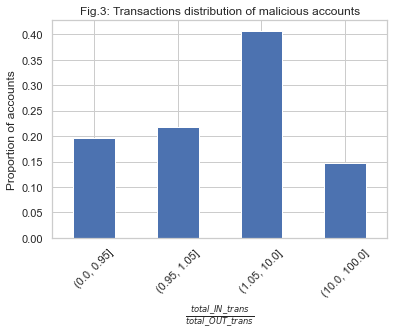

In [14]:
# distribution of transactions: ratio between total_IN_transactions / total_OUT_transactions
bar_plot(no_contract_trans['total_rec_trans'], no_contract_trans['total_sent_trans'], 
        bins=bins, xlabel=r'$\frac{total\_IN\_trans}{total\_OUT\_trans}$',
        ylabel='Proportion of accounts', title='Fig.3: Transactions distribution of malicious accounts'
        )

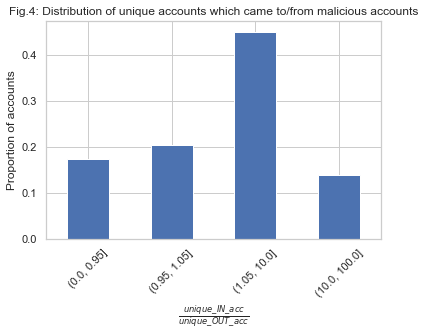

In [15]:
# distribution of transactions bases on UNIQUE senders/recepients: ratio between total_IN_unique_acc / total_OUT_unique_acc
bar_plot(no_contract_trans['#unique_rec_acc'], no_contract_trans['#unique_sent_acc'], 
        bins=bins, xlabel=r'$\frac{unique\_IN\_acc}{unique\_OUT\_acc}$',
        ylabel='Proportion of accounts', 
        title='Fig.4: Distribution of unique accounts which came to/from malicious accounts'
        )

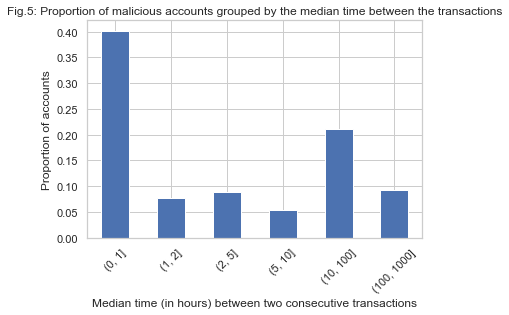

In [16]:
# plot the distribution of median time between two consecutive transactions
plot_df = pd.cut(no_contract_trans['median_trans_time']/3600, bins=[0, 1, 2, 5, 10, 100, 1000]).value_counts() / len(no_contract_trans)
plot_df = plot_df.iloc[plot_df.index.argsort()]
plot_df.plot.bar()
plt.xticks(rotation=45);
plt.xlabel('Median time (in hours) between two consecutive transactions')
plt.ylabel('Proportion of accounts')
plt.title('Fig.5: Proportion of malicious accounts grouped by the median time between the transactions');

## C.3. Given the different groups you have created, what would you advise the business to do?  

 - Fig.1: Accounts which run **only** smart contracts can be suspicious.
 - Fig.2: Around 90% of all malicious accounts are transition accounts, i.e., the same amount of ETH which comes in moves out. (Note: "all" here and below means all accounts which do not run smart contracts)
 - Fig.3: For majority (>60%) of accounts the total number of IN transactions larger than number of OUT transactions (e.g., because of the announcing fake mining pool).
 - Fig.4: The same is true as for Fig.3 for relation of unique IN vs OUT accounts.
 - Fig.5: The vast majority of malicious accounts have short median time between transactions which can be considered as suspicious behaviour.

## C.4. Train a prediction model that predicts maliciousness based on financial behavior.

### Export whitelist accounts

In [17]:
def parse_export_file(address:str):
    """
        Parse the exported CSV file with contract transactions from the etherscan.io website 
        Args:
            address: specify account address as a string
        Returns:
            List of unique accounts which requested to run the smart contract
    """
    filename = f'export-{address}.csv'
    if os.path.exists(filename):
        df = pd.read_csv(filename)
    else:
        print(f'File {filename} cannot be found...')
        return []
    col_names = df.columns
    df.drop(columns='Method', inplace=True)
    df.reset_index(inplace=True)
    df.columns = col_names
    df_add = list(set([x for x in df['From'] if x != address]))
    
    return df_add


In [18]:
# Source: https://github.com/MyEtherWallet/ethereum-lists/blob/master/src/addresses/addresses-lightlist.json
district0x_add = '0xF8094e15c897518B5Ac5287d7070cA5850eFc6ff'
dao_add = '0x439b54caf661c21e6b231d972d7eaa98f199590f'

white_add = set(parse_export_file(district0x_add) + parse_export_file(dao_add))
len(white_add)

2782

In [19]:
if load_saved_trans:
    if os.path.exists(white_trans_filename):
        all_white_trans_df = pd.read_csv(white_trans_filename, index_col=0)
    else:
        print(f'File {white_trans_filename} cannot be found ...')
else:
    all_white_trans_df = get_account_info(white_add, white_trans_filename)
all_white_trans_df

,acc_name,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,gas,gasPrice,isError,txreceipt_status,input,contractAddress,cumulativeGasUsed,gasUsed,confirmations
0,0x3074b30349574ff342b7dac4de924ef1408733c9,3690389,1494532357,0x8ef7a58c035e1ec5395fcae7c8458ee7c88f5d83533f...,1.0,0xbdf57945c79e97ac12b5060b6cd10b43c7d093c1d2c9...,4,0x929bb6b57c02e96f678b022e9fe0ed56829251c2,0x3074b30349574ff342b7dac4de924ef1408733c9,380000000000000000,21000,21000000000,0,NaN,0x,NaN,108426,21000,10668344
1,0x3074b30349574ff342b7dac4de924ef1408733c9,3690421,1494532846,0x0ba2b6b2c8bc44baa62c84ced6ed8b6dde1a950269d1...,0.0,0x0289470793fb4cee3ec4c6c2461d21152513b4e7ab9e...,0,0x3074b30349574ff342b7dac4de924ef1408733c9,0x6090a6e47849629b7245dfa1ca21d94cd15878ef,10000000000000000,650000,20000000000,0,NaN,0xfebefd61000000000000000000000000000000000000...,NaN,533513,533513,10668312
2,0x3074b30349574ff342b7dac4de924ef1408733c9,3690438,1494533104,0x515c56954c8cc8ffa015f349c584dd1a36cff593a282...,1.0,0xc44e287f8c1b225d3ad6b937dc4c838e778145f16985...,3,0x3074b30349574ff342b7dac4de924ef1408733c9,0x6090a6e47849629b7245dfa1ca21d94cd15878ef,10000000000000000,650000,21388869432,0,NaN,0xfebefd61000000000000000000000000000000000000...,NaN,621201,533513,10668295
3,0x3074b30349574ff342b7dac4de924ef1408733c9,3695420,1494609011,0x566c9eca14f698c25327fc8570aa3fc09e662ff64312...,2.0,0x9ee0eaa000a48e42207cd6b64245a0ff6a1dc353c347...,9,0x3074b30349574ff342b7dac4de924ef1408733c9,0x6090a6e47849629b7245dfa1ca21d94cd15878ef,10000000000000000,650000,20000000000,0,NaN,0xfebefd61000000000000000000000000000000000000...,NaN,737951,533449,10663313
4,0x3074b30349574ff342b7dac4de924ef1408733c9,3695428,1494609174,0x91db9ca4d994d0cf6ac45ea00d82339ee2f3f47d1ba4...,3.0,0x50e21916cf17525f6a11146ea31ee1eea97c1dccceb6...,40,0x3074b30349574ff342b7dac4de924ef1408733c9,0x6090a6e47849629b7245dfa1ca21d94cd15878ef,0,300000,20000000000,0,NaN,0x47872b42165409826174b18ef1f0c195d619ab6db815...,NaN,1452374,40224,10663305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793280,0xb7f1498898d70685851b5331f64bf26215f00415,14250210,1645456933,0x0ef2ad8fa8fbd5a3c5fe0d8e94dfc931d8a977aa0319...,1348.0,0x0bd8908c0206391f7cdb7149645d3d0412735f5a7ab6...,17,0xb7f1498898d70685851b5331f64bf26215f00415,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0,100000,126000000000,0,1.0,0x095ea7b3000000000000000000000000d9e1ce17f264...,NaN,884615,38027,108745
793281,0xb7f1498898d70685851b5331f64bf26215f00415,14250216,1645456988,0xdfb583c184d36b85255b4bf878cd3c3b2909f654f4f5...,1349.0,0xadb577736f37016c65051bffe9f9dd79278ccd4360ad...,10,0xb7f1498898d70685851b5331f64bf26215f00415,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0,100000,126000000000,0,1.0,0x095ea7b300000000000000000000000039aa39c021df...,NaN,1110606,38027,108739
793282,0xb7f1498898d70685851b5331f64bf26215f00415,14250220,1645457024,0xcf05a9b0191de4907e084b692f4f4521d1e43f7d4351...,1350.0,0x286369ad89796a7532927ff99e76f64abf1e4d50a5c1...,25,0xb7f1498898d70685851b5331f64bf26215f00415,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0,100000,124000000000,0,1.0,0x095ea7b3000000000000000000000000d6ad7a6750a7...,NaN,1803643,38027,108735
793283,0xb7f1498898d70685851b5331f64bf26215f00415,14250246,1645457308,0xb7fd7625e22c62b738edba01cd10224808cfcacb2389...,1351.0,0x96478f7be738af1ae32c141497111579ef595e51a3dd...,23,0xb7f1498898d70685851b5331f64bf26215f00415,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0,100000,101000000000,0,1.0,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,1113672,38027,108709


In [20]:
all_white_trans_df = trans_preprocess(all_white_trans_df, datetime_col, num_cols, obj_cols)


In [21]:
all_white_trans_grouped = build_features(all_white_trans_df)
all_white_trans_grouped

#Accounts which run smart contract transactions: 139


,is_contract,#zero_values,#error_trans,aver_trans_fee,value_sent_mean,value_rec_mean,value_sent_all,value_rec_all,total_rec_trans,#unique_rec_acc,total_sent_trans,#unique_sent_acc,median_trans_time
0x875ffc27d586a0d931e84f62f43bc52c68921cf3,0,5,1,0.001802,11.392001,25.387500,102.528008,101.550000,4,2,9,5,176608.5
0x87a1e3478d353bafbecfab9dd0d229b3f2b17853,0,3,0,0.001379,0.866593,1.326250,5.199559,5.305000,4,4,6,5,239995.0
0x3ab1ecee960045eb0af6039f2b8fa3464014e7ed,0,37,7,0.008370,8.540624,21.533583,452.653087,344.537334,16,3,53,22,12445.5
0xe7269c522d40b0d26d2e9cf26b857f04a04c9afe,0,0,0,0.000395,1.800000,1.843859,1.800000,3.687718,2,2,1,1,317064.0
0xdd793946cafd3c2b91df5ce3f602136bc5b45f8a,0,6,1,0.001099,8.049266,4.045243,136.837520,76.859614,19,8,17,13,885.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xed7047adb39f9df923eb692d2d73ce79873fd150,0,97,17,0.002647,1.296821,3.529563,164.696249,77.650376,22,8,127,40,11113.5
0x94aea131d0f1b7c507569abbd097d2619cc09a92,0,17,2,0.000732,0.568182,1.012364,23.863653,20.247284,20,9,42,23,93419.0
0xc4c920f6e1dca4e6fadaeb854943500e7bbe3893,0,2,0,0.006105,1.128000,2.126246,12.408000,6.378738,3,2,11,10,851251.0
0x5044a5d4ab373384d4bdd84935c1b4b15921ac13,0,4,0,0.002306,0.525108,1.847500,3.675755,3.695000,2,2,7,5,2710793.0


In [22]:
# add target column labels:
#   0 - white accounts
#   1 - malicious accounts
target_col = 'label'
all_mal_trans_grouped[target_col] = 1
all_white_trans_grouped[target_col] = 0

# merge malicious and white account details together
all_accounts = all_mal_trans_grouped.append(all_white_trans_grouped)
# shuffle the dataframe
all_accounts = all_accounts.sample(frac=1, random_state = random_state)
all_accounts

,is_contract,#zero_values,#error_trans,aver_trans_fee,value_sent_mean,value_rec_mean,value_sent_all,value_rec_all,total_rec_trans,#unique_rec_acc,total_sent_trans,#unique_sent_acc,median_trans_time,label
0x581cc257051a34972641d008c3915a75771be274,1,0,0,0.000360,0.000000,0.000000,0.000000,0.000000,7,4,1,1,117081.5,1
0xb9e34ab79c29f182f4ff40399d6e1885abe23067,0,64,17,0.001388,0.213380,1.019077,32.433798,29.553244,29,14,152,98,38650.0,0
0x27b1b0493c1cb83a24e455be44f4580c502b0b98,0,15,1,0.005006,0.296482,0.505757,6.819087,2.528783,5,5,23,12,3860.0,0
0x2879cf6519557ebd7284fc34e5e787391ad0e9bc,0,0,1,0.002433,16.630446,25.000000,49.891338,25.000000,1,1,3,2,921.0,0
0xaf11cce7a51a51abdb235cd360c7d07b8f5048a9,0,2,0,0.000495,0.014857,0.095500,0.044570,0.095500,1,1,3,2,926.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x82a4c420b30881b122cc0e59e06ac2c7bfff465a,0,5,0,0.001250,0.999946,2.253130,8.999510,9.012520,4,4,9,7,702032.0,0
0x85e3f4b00367a383f0fccfddce109f642127c3ee,0,60,1,0.001657,3.791385,30.823763,246.440000,246.590105,8,4,65,11,91409.0,0
0x404b688a1d9eb850be2527c5dd341561cfa84e11,0,48,8,0.002089,0.109839,0.806169,11.203577,10.480196,13,13,102,54,59313.0,0
0x4b0250098cf3f62f4595be93d8c0afcfe0bd63f1,0,84,28,0.001105,0.127529,0.232887,21.169792,13.507450,54,34,162,124,7860.0,0


In [23]:
# print label distribution
all_accounts['label'].value_counts()

0    2778
1     550
Name: label, dtype: int64

### Run prediction models (binary classifier)

In [24]:
# for running the model change to True, if you don't want to run that model change the value to False
regression = True
decision_tree = True
random_forest = True
gbc = True
nn = True
adaboost = True

#set true for selecting test set false otherwise
val_flag = True
# percentage of testing data (in decimal format)
test_percentage = 0.3

# Evaluate classification model with binary output
def evaluate_model(model, x_test, y_test ,modelname, weight=None):
    """
        Return basic statistics for Binary classification model
    """
    y_model = model.predict(x_test)
    confusion_matrix = metrics.confusion_matrix(y_test, y_model, sample_weight=weight)
    accuracy = metrics.accuracy_score(y_test, y_model, sample_weight=weight)
    precision = metrics.precision_score(y_test, y_model, average = None)
    recall = metrics.recall_score(y_test, y_model, sample_weight=weight, average = None)
    f1_score = metrics.f1_score(y_test, y_model, sample_weight=weight, average = None)
    auc = metrics.roc_auc_score(y_test, y_model, sample_weight=weight, average = None)

    print("\nEvaluation of Modeltyp: " + modelname)
    print("Confusion matrix: ")
    print(confusion_matrix)
    print()
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 score: ", f1_score)
    print("AUC: ", auc)
    metrics.plot_confusion_matrix(model, x_test, y_test)
    plt.show()
    
    
def graph_model(model, x_test, y_test, modelname, weight=None):
    """
        Plot AUC ROC curve
    """
    y_model = model.predict(x_test)
    roc_auc_score = metrics.roc_auc_score(y_test, y_model, sample_weight=weight)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:, 1], sample_weight=weight)
    plt.figure()
    plt.plot(fpr, tpr, label='(area = %0.2f)' % roc_auc_score)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: ' +modelname)
    plt.legend(loc="lower right")
    plt.show()
   

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 <a list of 12 Text major ticklabel objects>)

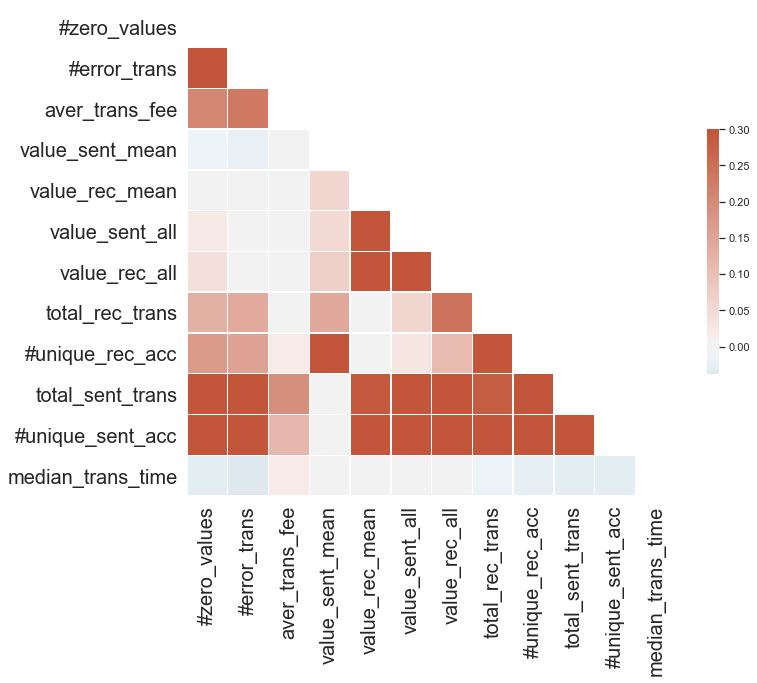

In [46]:
# check correlation between all the input features
# Compute the correlation matrix
corr = all_accounts[all_accounts.columns[:-1]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)


In [25]:
# split the data into features and target column
X = all_accounts[all_accounts.columns[:-1]]
y = all_accounts[target_col].to_frame()

# check correlation between all the input features
# plt.matshow(X.corr())
# plt.show()

# extract the names of the features
features = X.columns

# scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# perform train/test split
if val_flag:
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                      test_size = test_percentage, random_state=random_state)
    
len(X_train), len(X_val)

(2329, 999)

In [26]:
model_names_dict = {
               'log_reg' : 'logisticRegression',
               'tree' : 'DecisionTree',
               'forest' : 'RandomForest',
               'GBC' : 'GBC',
               'NN' : 'NN',
               'AdaBoost' : 'AdaBoost'
              }

def choose_classifier(model_name, auto_class_weights=True, random_state=42):
    if model_name == 'log_reg':
        model_default = LogisticRegression(solver='saga', class_weight = 'balanced', random_state=random_state) # class_weight = 'balanced'
    elif model_name == 'tree':
        model_default = DecisionTreeClassifier(max_depth=10, class_weight = 'balanced', min_samples_leaf=10, random_state=random_state)
    elif model_name == 'forest':
        model_default = RandomForestClassifier(class_weight = 'balanced', random_state=random_state)
    elif model_name == 'GBC':
        model_default = GradientBoostingClassifier() # no class weights
    elif model_name == 'NN':
        model_default = MLPClassifier()
    elif model_name == 'AdaBoost':
        model_default = AdaBoostClassifier()
    else:
        print(f'The specified model name {model_name} is not supported')
        return None
    
    return model_default


def run_model(model_name, X_train, y_train, X_val, y_val, target,
              is_regression = False, test_flag = True):
    start = time.time()
    if not is_regression:
        model_default = choose_classifier(model_name)
    else:
        model_default = choose_regressor(model_name)
    model_default.fit(X_train, y_train[target])
    end = time.time()
    minutes_diff = np.round((end - start) / 60.0, 3)
    print("Time taken for training model is",minutes_diff,"minutes.")
    if test_flag:
        print("Validation results")
        if is_regression:
            evaluate_reg_model(model_default, X_val, y_val, f'{model_names_dict[model_name]}-TestData')
        else:
            evaluate_model(model_default, X_val, y_val[target], f'{model_names_dict[model_name]}-TestData')
            graph_model(model_default, X_val, y_val[target], f'{model_names_dict[model_name]}-TestData')
    
    return model_default

def call_model(model_flag, model_name, X_train, y_train, X_val, y_val,
               target, is_regression = False, test_flag=True):
    if model_flag:
        print('\n######################################')
        print(f'[Processing {model_names_dict[model_name]}]\n')
        model = run_model(model_name, X_train, y_train, X_val, y_val, 
                          target=target, is_regression = is_regression,
                          test_flag = test_flag)
        return model


######################################
[Processing logisticRegression]

Time taken for training model is 0.001 minutes.
Validation results

Evaluation of Modeltyp: logisticRegression-TestData
Confusion matrix: 
[[671 161]
 [ 13 154]]

Accuracy:  0.8258258258258259
Precision:  [0.98099415 0.48888889]
Recall:  [0.80649038 0.92215569]
F1 score:  [0.88522427 0.63900415]
AUC:  0.8643230366190695


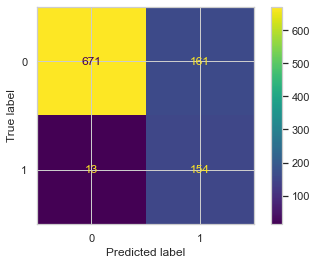

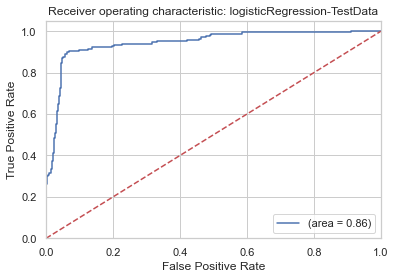

In [27]:
model_lr_default = call_model(regression, 'log_reg', X_train, y_train,
                              X_val, y_val, target = target_col,
                              test_flag = val_flag
                             )


######################################
[Processing DecisionTree]

Time taken for training model is 0.0 minutes.
Validation results

Evaluation of Modeltyp: DecisionTree-TestData
Confusion matrix: 
[[788  44]
 [ 15 152]]

Accuracy:  0.9409409409409409
Precision:  [0.98132005 0.7755102 ]
Recall:  [0.94711538 0.91017964]
F1 score:  [0.96391437 0.83746556]
AUC:  0.9286475126669738


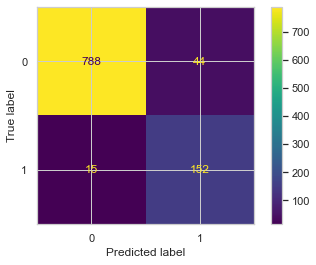

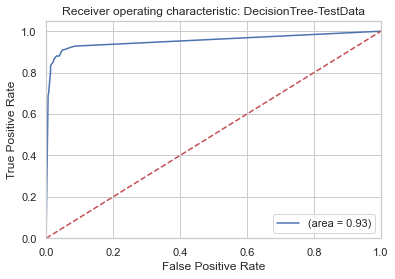

In [28]:
model_tree_default = call_model(decision_tree, 'tree', X_train, y_train,
                              X_val, y_val, target = target_col,
                              test_flag = val_flag
                             )


######################################
[Processing RandomForest]

Time taken for training model is 0.014 minutes.
Validation results

Evaluation of Modeltyp: RandomForest-TestData
Confusion matrix: 
[[824   8]
 [ 24 143]]

Accuracy:  0.9679679679679679
Precision:  [0.97169811 0.94701987]
Recall:  [0.99038462 0.85628743]
F1 score:  [0.98095238 0.89937107]
AUC:  0.923336020267158


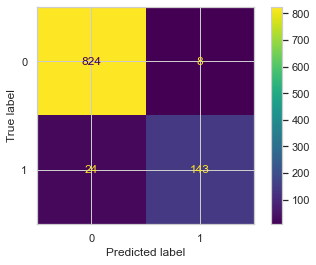

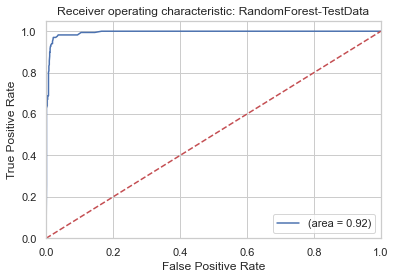

In [29]:
model_forest_default = call_model(random_forest, 'forest', X_train, y_train,
                              X_val, y_val, target = target_col,
                              test_flag = val_flag
                             )


######################################
[Processing GBC]

Time taken for training model is 0.012 minutes.
Validation results

Evaluation of Modeltyp: GBC-TestData
Confusion matrix: 
[[817  15]
 [ 17 150]]

Accuracy:  0.9679679679679679
Precision:  [0.97961631 0.90909091]
Recall:  [0.98197115 0.89820359]
F1 score:  [0.98079232 0.90361446]
AUC:  0.9400873733302625


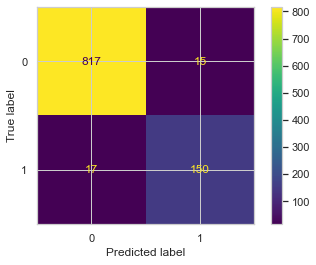

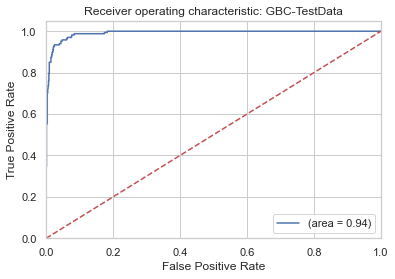

In [30]:
model_gbc_default = call_model(gbc, 'GBC', X_train, y_train,
                              X_val, y_val, target = target_col,
                              test_flag = val_flag
                             )


######################################
[Processing NN]

Time taken for training model is 0.034 minutes.
Validation results

Evaluation of Modeltyp: NN-TestData
Confusion matrix: 
[[815  17]
 [ 39 128]]

Accuracy:  0.943943943943944
Precision:  [0.95433255 0.88275862]
Recall:  [0.97956731 0.76646707]
F1 score:  [0.96678529 0.82051282]
AUC:  0.8730171867802856


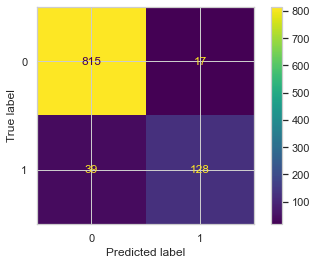

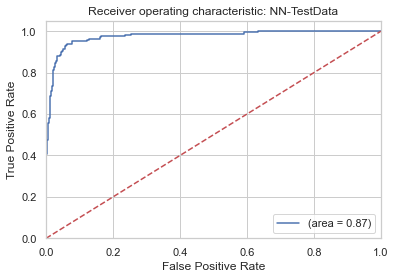

In [31]:
model_nn_default = call_model(nn, 'NN', X_train, y_train,
                              X_val, y_val, target = target_col,
                              test_flag = val_flag
                             )


######################################
[Processing AdaBoost]

Time taken for training model is 0.004 minutes.
Validation results

Evaluation of Modeltyp: AdaBoost-TestData
Confusion matrix: 
[[813  19]
 [ 25 142]]

Accuracy:  0.955955955955956
Precision:  [0.97016706 0.88198758]
Recall:  [0.97716346 0.8502994 ]
F1 score:  [0.97365269 0.86585366]
AUC:  0.9137314313680333


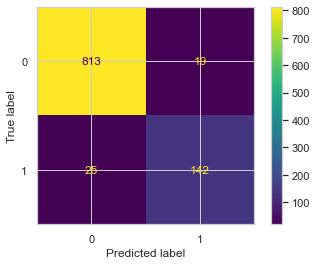

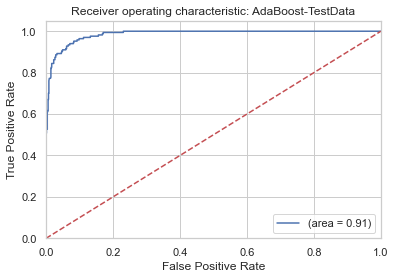

In [32]:
model_adaboost_default = call_model(adaboost, 'AdaBoost', X_train, y_train,
                              X_val, y_val, target = target_col,
                              test_flag = val_flag
                             )

In [33]:
def compute_feature_importance(model_name, model, features, is_plot=True):
    """
        Compute and plot the most important features
        Args:
            model_name: str, specify the model name for which the most important features should be extracted
            model: sklearn-object, pass the trained model
            features: list of features
            is_plot: boolean, indicate if the plotting is necessary
        Returns:
            List of features sorted in descending order by their importance and plots them if the corresponding 
            flag is_plot = True
    """
    
    if model_name == 'log_reg':
        importance = model.coef_[0]
    elif model_name == 'tree':
        importance = model.feature_importances_
    elif model_name == 'forest':
        importance = model.feature_importances_
    elif model_name == 'GBC':
        importance = model.feature_importances_
    elif model_name == 'NN':
        print('Feature importance is not supported for MLPClassifier()')
        return None
    elif model_name == 'AdaBoost':
        importance = model.importances_mean
    
    importance =sorted((importance), reverse=True)
    # summarize feature importance
    for i,v in enumerate(importance):
        print('%s, Score: %.5f' % (features[i],v))
    #plot feature importance
    if is_plot:
        plt.bar([x for x in range(len(importance))], importance)
        plt.show()

    return importance

is_contract, Score: 2.01561
#zero_values, Score: 0.87806
#error_trans, Score: 0.61125
aver_trans_fee, Score: 0.47213
value_sent_mean, Score: 0.13026
value_rec_mean, Score: -0.06420
value_sent_all, Score: -0.10664
value_rec_all, Score: -0.48561
total_rec_trans, Score: -0.79584
#unique_rec_acc, Score: -1.03625
total_sent_trans, Score: -2.00997
#unique_sent_acc, Score: -2.97229
median_trans_time, Score: -3.01512


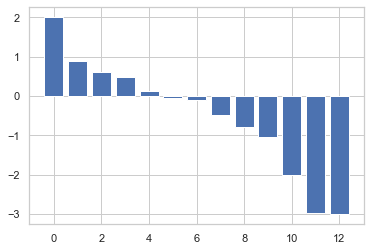

In [34]:
if regression:
    importance = compute_feature_importance('log_reg', model_lr_default, features)

is_contract, Score: 0.58304
#zero_values, Score: 0.11790
#error_trans, Score: 0.09324
aver_trans_fee, Score: 0.04120
value_sent_mean, Score: 0.03892
value_rec_mean, Score: 0.03496
value_sent_all, Score: 0.03416
value_rec_all, Score: 0.02101
total_rec_trans, Score: 0.02050
#unique_rec_acc, Score: 0.00675
total_sent_trans, Score: 0.00615
#unique_sent_acc, Score: 0.00218
median_trans_time, Score: 0.00000


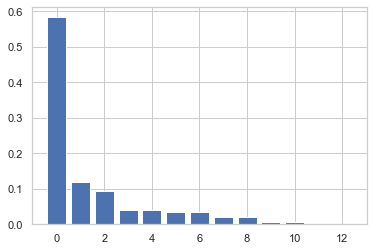

In [35]:
if decision_tree:
    importance = compute_feature_importance('tree', model_tree_default, features)

is_contract, Score: 0.18750
#zero_values, Score: 0.16097
#error_trans, Score: 0.12469
aver_trans_fee, Score: 0.12188
value_sent_mean, Score: 0.10557
value_rec_mean, Score: 0.06381
value_sent_all, Score: 0.04988
value_rec_all, Score: 0.04323
total_rec_trans, Score: 0.04031
#unique_rec_acc, Score: 0.03580
total_sent_trans, Score: 0.03460
#unique_sent_acc, Score: 0.02794
median_trans_time, Score: 0.00382


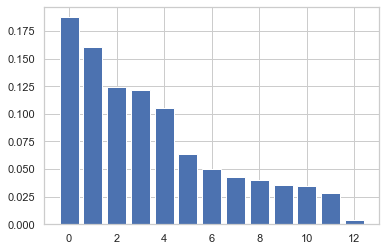

In [36]:
if random_forest:
    importance = compute_feature_importance('forest', model_forest_default, features)